In [23]:
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 
dpkg: dependency problems prevent removal of cuda-cccl-11-8:
 cuda-cudart-dev-11-8 depends on cuda-cccl-11-8.

dpkg: error processing package cuda-cccl-11-8 (--purge):
 dependency problems - not removing
Errors were encountered while processing:
 cuda-cccl-11-8
dpkg: dependency problems prevent removal of cuda-command-line-tools-9-2:
 cuda-tools-9-2 depends on cuda-command-line-tools-9-2 (>= 9.2.88).

dpkg: error processing package cuda-command-line-tools-9-2 (--purge):
 dependency problems - not removing
Errors were encountered while processing:
 cuda-command-line-tools-9-2
(Reading database ... 131664 files and directories currently installed.)
Removing cuda-compiler-9-2 (9.2.88-1) ...
dpkg: dependency problems prevent removal of cuda-cublas-9-2:
 cuda-cublas-dev-9-2 depends on cuda-cublas-9-2 (>= 9.2.88); however:
  Package cuda-cublas-9-2 is to be removed.

dpkg: error processing package c

In [25]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2023-05-11 15:27:05--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/downloads/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2023-05-11 15:27:06--  https://developer.nvidia.com/downloads/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?OqWjJxyGvDGGj4qT-OWFVjSeX3vg1KcVzMpBZmwneh0Qq6Ci80eAd1aAMXt3jShm6nQgVgKqcGtdXd29BgGfFHGEo

In [26]:
!nvcc --version

/bin/bash: nvcc: command not found


In [27]:
%load_ext nvcc_plugin

ModuleNotFoundError: ignored

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-vmuwsoou
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-vmuwsoou
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4287 sha256=a71c2c5e545588d790a7ea4ee8feae05cb9909dd92ac2b2b6f81ba9ac894633a
  Stored in directory: /tmp/pip-ephem-wheel-cache-xehygtow/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin


In [30]:
dataf=open('/content/drive/My Drive/Financial_Fraud_Datasets.csv', 'rb')
dataf

<_io.BufferedReader name='/content/drive/My Drive/Financial_Fraud_Datasets.csv'>

In [31]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import*
#from pyspark.sql.types import*

# Load the CSV file into a Pandas DataFrame
pandas_df = pd.read_csv(dataf, header=0, infer_datetime_format=True, parse_dates=["step"],error_bad_lines=False)

# Rename columns to replace camelCase with snake_case
pandas_df = pandas_df.rename(columns={"oldbalanceOrg": "old_balance_org",
                                       "newbalanceOrig": "new_balance_orig",
                                       "oldbalanceDest": "old_balance_dest",
                                       "newbalanceDest": "new_balance_dest"})

# Convert "type" column to binary "isFraud" column
pandas_df["isFraud"] = pandas_df["type"].apply(lambda x: 1 if x in ("TRANSFER", "CASH_OUT") else 0)

# Drop unnecessary columns
pandas_df = pandas_df.drop([ "nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

# Show the first 10 rows
print(pandas_df.head(10))

# Print the schema of the DataFrame
pandas_df.head()

<ipython-input-31-d56ea024a371>:17: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pandas_df = pd.read_csv(dataf, header=0, infer_datetime_format=True, parse_dates=["step"],error_bad_lines=False)


  step      type    amount  old_balance_org  new_balance_orig  \
0    1   PAYMENT   9839.64        170136.00         160296.36   
1    1   PAYMENT   1864.28         21249.00          19384.72   
2    1  TRANSFER    181.00           181.00              0.00   
3    1  CASH_OUT    181.00           181.00              0.00   
4    1   PAYMENT  11668.14         41554.00          29885.86   
5    1   PAYMENT   7817.71         53860.00          46042.29   
6    1   PAYMENT   7107.77        183195.00         176087.23   
7    1   PAYMENT   7861.64        176087.23         168225.59   
8    1   PAYMENT   4024.36          2671.00              0.00   
9    1     DEBIT   5337.77         41720.00          36382.23   

   old_balance_dest  new_balance_dest  isFraud  
0               0.0              0.00        0  
1               0.0              0.00        0  
2               0.0              0.00        1  
3           21182.0              0.00        1  
4               0.0              0.00  

,step,type,amount,old_balance_org,new_balance_orig,old_balance_dest,new_balance_dest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [32]:
pandas_df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [33]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
pandas_df['type']=le.fit_transform(pandas_df['type'])

In [34]:
pandas_df.head()
#pandas_df['type'].unique()

,step,type,amount,old_balance_org,new_balance_orig,old_balance_dest,new_balance_dest,isFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


In [35]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


Computing transition probabilities:   0%|          | 0/265 [00:00<?, ?it/s]

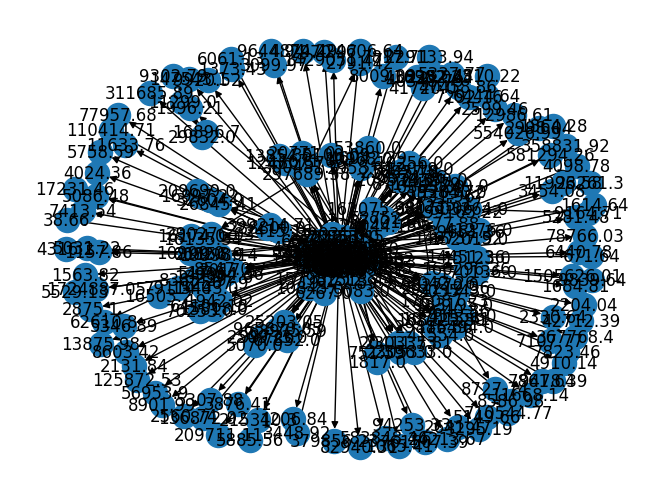

In [36]:
import matplotlib.pyplot as plt

# Load the CSV file into a Pandas DataFrame
#pandas_df = pd.read_csv("Financial_Fraud_Datasets.csv", header=0, infer_datetime_format=True, parse_dates=["step"],error_bad_lines=False)

# Rename columns to replace camelCase with snake_case
#pandas_df = pandas_df.rename(columns={"oldbalanceOrg": "old_balance_org",
                                    #   "newbalanceOrig": "new_balance_orig",
                                     #  "oldbalanceDest": "old_balance_dest",
                                     #  "newbalanceDest": "new_balance_dest"})

# Create a directed graph from the data
G = nx.DiGraph()
#################data_collect = df.collect()
 
# looping thorough each row of the dataframe

for index, row in pandas_df.head(100).iterrows():
    G.add_edge(row['step'], row['new_balance_orig'])
    G.add_edge(row['new_balance_orig'], row['old_balance_dest'])
    G.add_edge(row['old_balance_dest'], row['new_balance_dest'])
    G.add_edge(row['new_balance_dest'], row['old_balance_org'])
    G.add_edge(row['old_balance_org'], row['new_balance_orig'])
    G.add_edge(row['new_balance_orig'], row['amount'])

# Generate node2vec features for the graph
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = model.wv
node_embeddings.save_word2vec_format('node_embeddings.bin')

# Extract features for the fraud detection model
#df_features = spark.DataFrame(node_embeddings.vectors, index=node_embeddings.index2word)
#df_features.reset_index(inplace=True)
#df_features = df_features.rename(columns={'index': 'id'})

df_features = pd.DataFrame(node_embeddings.vectors, index=node_embeddings.index_to_key)
df_features.reset_index(inplace=True)
df_features = df_features.rename(columns={'index': 'id'})


pandas_df['id'] = pandas_df.index.astype(str)
#pandas_df = pandas_df.merge(df_features, on='id', how='left')

# Split the data into training and testing sets
X = pandas_df.drop(['id', 'isFraud'], axis=1)

y = pandas_df['isFraud']

nx.draw(G,with_labels=True)
plt.show();

In [37]:
X= X.dropna(axis = 0)

In [38]:
X.columns = X.columns.astype(str) 
for i in range(0,64):
  X[f'{i}'] = X[f'{i}'].fillna(X[f'{i}'].mean(), inplace=False)

KeyError: ignored

In [39]:
X.isnull().any()

step                False
type                False
amount              False
old_balance_org     False
new_balance_orig    False
old_balance_dest    False
new_balance_dest    False
dtype: bool

In [40]:
X.columns = X.columns.astype(str) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Train the logistic regression model
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#clf.to(device)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

#print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

#nx.draw(G,with_labels=True)
plt.show();


Accuracy: 0.9143080994936048
Precision: 0.8960965001263557
Recall: 0.9085843484913828
F1 score: 0.9022972182325961


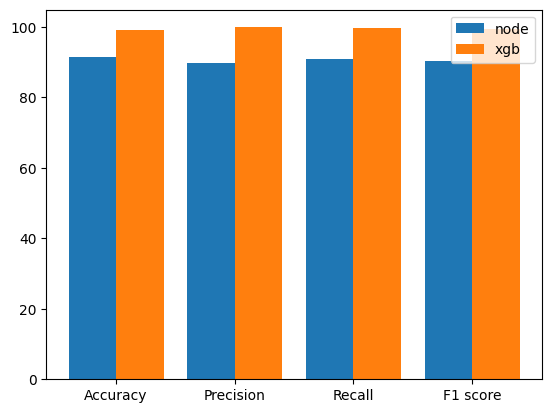

In [41]:
X = ['Accuracy','Precision','Recall','F1 score']
node = [accuracy_score(y_test, y_pred)*100,precision_score(y_test, y_pred)*100,recall_score(y_test, y_pred)*100,f1_score(y_test, y_pred)*100]
xgb = [99,99.86,99.7,99.3]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, node, 0.4, label = 'node')
plt.bar(X_axis + 0.2, xgb, 0.4, label = 'xgb')
  
plt.xticks(X_axis, X)

plt.legend()
plt.show()

In [42]:
from gensim.models import Word2Vec
import networkx as  nx
# Load the CSV file into a Pandas DataFrame
#pandas_df = pd.read_csv("Financial_Fraud_Datasets.csv", header=0, infer_datetime_format=True, parse_dates=["step"],error_bad_lines=False)

# Rename columns to replace camelCase with snake_case
#pandas_df = pandas_df.rename(columns={"oldbalanceOrg": "old_balance_org",
                                    #   "newbalanceOrig": "new_balance_orig",
                                     #  "oldbalanceDest": "old_balance_dest",
                                     #  "newbalanceDest": "new_balance_dest"})

# Create a directed graph from the data
G = nx.from_pandas_edgelist(pandas_df, source='old_balance_dest', target='new_balance_dest')

# Generate random walks on the graph using DeepWalk algorithm
walks = []
num_walks = 10
walk_length = 80
for node in G.nodes():
    for i in range(num_walks):
        walk = nx.random_walk(G, node, walk_length)
        walks.append(walk)

# Train a Word2Vec model on the random walks
model = Word2Vec(walks, size=128, window=10, min_count=0, sg=1, workers=8)

# Prepare the data for machine learning
X = np.array([model.wv[str(node)] for node in G.nodes()])
y = np.array(pandas_df['isFraud'])




X.columns = X.columns.astype(str) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Train the logistic regression model
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#clf.to(device)

# Make predictions on the testing set
y_pred = clf.predict(X_test)
#print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))


AttributeError: ignored

In [ ]:
print(accuracy)
print(precision)
print(recall)
print(f1)

Accuracy : 0.9999909760649146
Precision : 1.0
Recall : 0.9970059880239521
F1 Score : 0.9985007496251874

